In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from matplotlib.dates import DateFormatter

In [2]:
# Reading the dataset

COLUMNS = ["year", "month", "day", "hour", "minute", "dhi", "dni", "ghi", "temperature"]

df = pd.read_csv('dataset.csv')

df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M')

18068

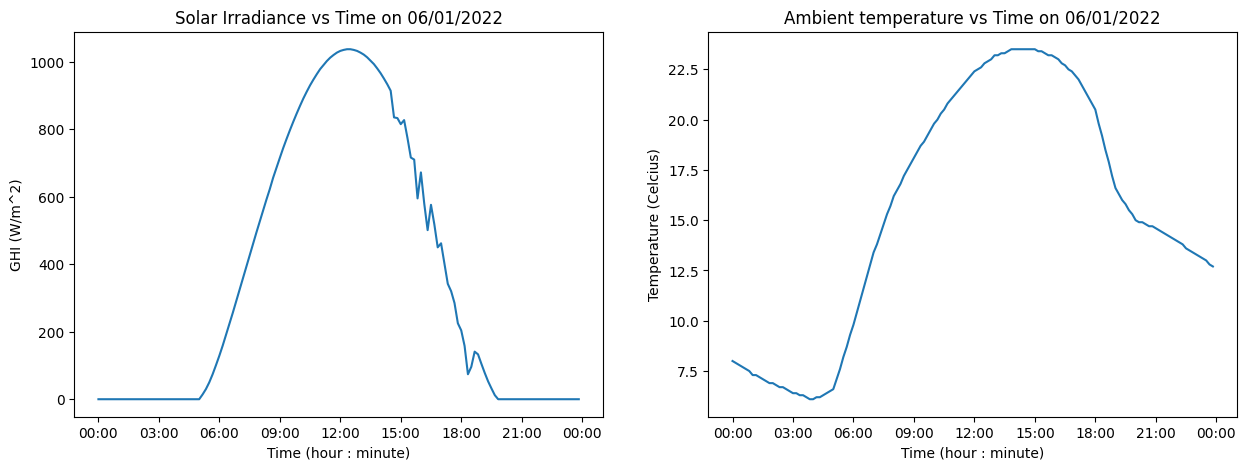

In [3]:
# Display the read solar irradiance and temperature vs Time
# The plot is shown for 06/01/2022

plotdf = df[(df['year'] == 2022) & (df['month'] == 6) & (df['day'] == 1)]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

PLOTS = [
    {
        'plot': 'ghi',
        'xlabel': 'Time (hour : minute)',
        'ylabel': 'GHI (W/m^2)',
        'title': 'Solar Irradiance vs Time on 06/01/2022'
    },
    {
        'plot': 'temperature',
        'xlabel': 'Time (hour : minute)',
        'ylabel': 'Temperature (Celcius)',
        'title': 'Ambient temperature vs Time on 06/01/2022'
    }
]

for i, ax in enumerate(fig.axes):
  ax.plot(plotdf['timestamp'], plotdf[PLOTS[i]['plot']])
  ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
  ax.set_title(PLOTS[i]['title'])
  ax.set_xlabel(PLOTS[i]['xlabel'])
  ax.set_ylabel(PLOTS[i]['ylabel'])

f = open("dataset.json", "w")
f.write(plotdf.to_json(orient="records"))

In [13]:
def useful_heat_from_collector(I, Tair, Tin, Ac, FU, FTA):
  # Q_solar_useful is the useful heat collected from the sun
  #
  # Q_min_loss is the minimum heat loss at the collector to the surroundings
  #
  # Q_useful is the heat that is useful to use at the collector

  Q_solar_useful = FTA * Ac * I

  Q_min_loss_useful = FU * Ac * (Tin - Tair)

  Q_useful = Q_solar_useful - Q_min_loss_useful

  return Q_useful

def output_temperature_from_collector(Q, Ac, Tin, m, Cw, Pl, Pr):
  # Q is the total heat we get from the collector accross its entire area

  Q_from_collector = ((Q/Ac) * (2 * 3.14 * Pr * Pl))/(m * Cw)
  Thot = Q_from_collector + Tin

  return Thot

def new_tank_temperature(toLoad, Thot, Tprev, Tmains, rho, Vt, delta_t, m):
  # Using energy balance equation
  # U =  Q + W + (hin - hout)
  # Assuming there is no heat loss, no extra heat is supplied to the tank and there is no work
  #
  # Q = 0
  # W = 0
  #
  # The only way heat enters and leaves is through the enthalpy of water entering and leaving the tank

  Tfinal = 0;

  if toLoad:
      Tfinal = (delta_t * m * Thot + Tprev * rho * Vt + delta_t * m * Tmains) / (rho * Vt + 2 * delta_t * m);
  else:
      Tfinal = (delta_t * m * Thot + Tprev * rho * Vt) / (rho * Vt + delta_t * m);

  return Tfinal;

In [25]:
# Calculate temperature variation for 06/01/2022

data = df[(df['year'] == 2022) & (df['month'] == 6) & (df['day'] == 1)]
data = data[['ghi', 'temperature', 'timestamp']]

# I Solar irradiance (W/m^2)
# Tair Temperature of surrounding air around the collector

Twater = 20
ts = 10 # 10 minutes

Ac = 4 # (m^2)
Pr = 0.04
Pl = 4

# Ul Overall collector heat loss coefficient
# tau Collector transmittance factor
# alpha Collector absorbance factor

FTA = 0.7
FU = 3 # W/m^2 C

m = .3 # Water pump rate (kg/s)

Cw = 4182 # Specific heat capacity of water (J/kg C)
rho = 995 # Density of water (kg/m^3)

Vt = .1 # Volume of tank in m^3 or 300L

def simulation(toLoad):
  Tin = Twater # Input Water temperature at the collector coming from the tank

  Tarr = []
  Qarr = []
  Tairarr = []
  Iarr = []

  index = 0

  for ind, row in data.iterrows():
    I = row['ghi']
    Tair = row['temperature']

    if index == 0:
      Iarr.append(I)
      Tairarr.append(Tair)

      Qarr.append(0)
      Tarr.append(Tin)
      index += 1

      continue

    for i in range(ts * 60):
      # We need to do this because every second the Tin changes for the collector
      # Merely providing ts = 600 doesn't account for the temperature change in water that
      # is entering the collector every second inside useful_heat_from_collector

      Q = useful_heat_from_collector(I, Tair, Tin, Ac, FU, FTA)
      Thot = output_temperature_from_collector(Q, Ac, Tin, m, Cw, Pl, Pr)

      Tt = new_tank_temperature(toLoad, Thot, Tin, Twater, rho, Vt, 1, m)
      Tin = Tt

    Iarr.append(I)
    Tairarr.append(Tair)

    Qarr.append(Q)
    Tarr.append(Tin)

    index += 1

  plt.plot(data['timestamp'], data['temperature'], label = 'Ambient Temperature')
  plt.plot(data['timestamp'], Tarr, label = 'Water temperature')
  plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
  plt.title(f'Change in tank water temperature and ambient tempearture on 06/01/2022 when toLoad = {toLoad}')
  plt.xlabel('Time (hour : minute)')
  plt.ylabel('Temperature (Celcius)')
  plt.legend()
  plt.show()

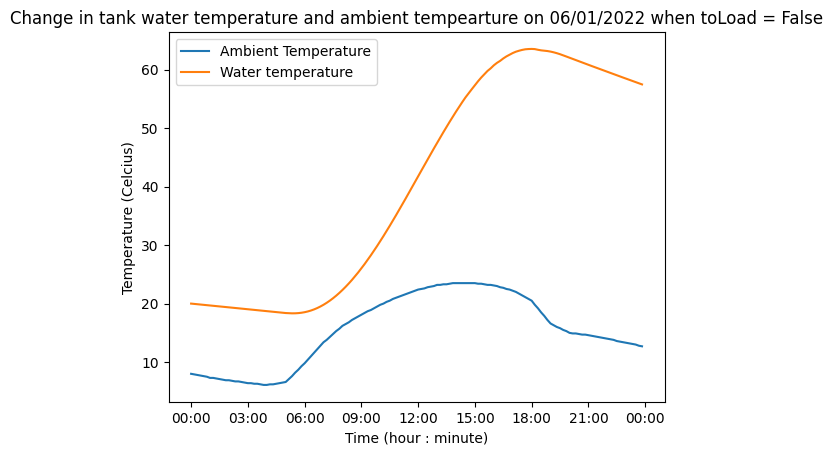

In [26]:
simulation(False)

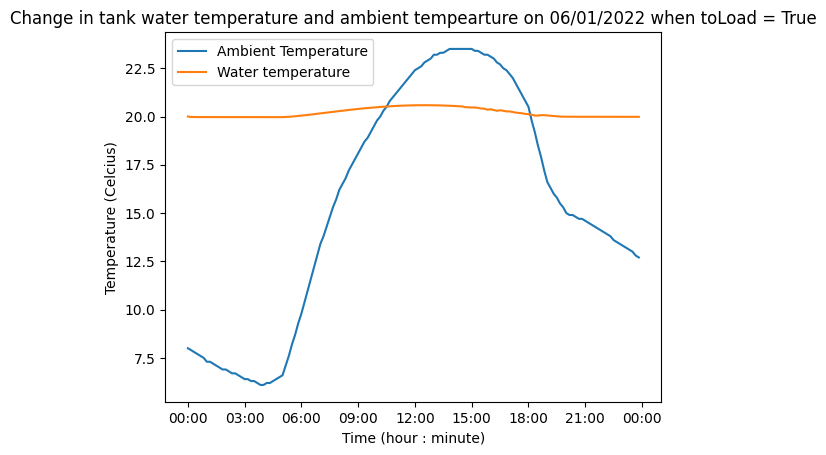

In [27]:
simulation(True)